# Burunup

The purpose of this notebook is to carry out a burnup calculation of the basic LEU PWR model.

In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

In [2]:
fuel = openmc.Material(name="uo2")
fuel.add_element("U", 1, percent_type="ao", enrichment=4.5)
fuel.add_element("O", 2)
fuel.set_density("g/cc", 10.5)

clad = openmc.Material(name='clad');
clad.add_element("Zr",1);
clad.set_density('g/cc',6.0);

water = openmc.Material(name='water');
water.add_element('O',1);
water.add_element('H',2)
water.set_density('g/cc',0.712); # high temperature density
water.add_s_alpha_beta('c_H_in_H2O');

materials = openmc.Materials([fuel,clad,water]);

## Pin Cell Geometry

The goal is to establish a pin-cell to provide a simplified representation of the basic criticality and (especially) neutron energy spectrum for this concept.  

In [3]:
h_core = 300.; 
h_fuel = 200.;

r_fuel = 0.42;
r_pin = 0.45;

P_D = 1.4;

pitch = P_D*(2*r_pin);

fuel_temp = 900; # K, representative fuel temperature
mod_temp = 600; # K, representative moderator temperature

# fuel cylinder:
fuel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel, r_fuel);

fuel.volume = np.pi*(r_fuel**2)*h_fuel; # needed for burnup calculation

# pin cylinder
pin_cyl = openmc.model.RightCircularCylinder([0.,0.,-(h_fuel+(r_pin-r_fuel))/2.],
                                            h_fuel+(r_pin-r_fuel)*2.,r_pin);

# pin cell container
core_cell = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
                                                  -pitch/2.,pitch/2.,
                                                  -h_core/2.,h_core/2.,
                                                  boundary_type='reflective');

fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl
fuel_cell.fill = fuel;
fuel_cell.temperature = fuel_temp;


clad_cell = openmc.Cell();
clad_cell.region = +fuel_cyl & -pin_cyl;
clad_cell.fill = clad;

mod_cell = openmc.Cell();
mod_cell.region = +pin_cyl & -core_cell;
mod_cell.fill = water

root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,clad_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;



materials.export_to_xml();
geometry.export_to_xml();



In [4]:
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 200;
settings.inactive = 50

box = openmc.stats.Box(lower_left = (-r_fuel,-r_fuel,-h_fuel/2.),
                      upper_right = (r_fuel,r_fuel,h_fuel/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);

settings.source = src;

settings.temperature['method']='interpolation';

settings.export_to_xml();

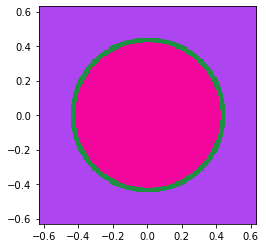

In [5]:
root_univ.plot(width=(pitch,pitch));

In [6]:
# get flux energy spectrum in the fuel

# filter for the fuel cell
cell_filter = openmc.CellFilter(fuel_cell)

# set up energy bins
N = 1001
energy_bins = np.logspace(-3,7,num=N)
energy_filter = openmc.EnergyFilter(values=energy_bins)

# establish flux tally
flux = openmc.Tally(name='flux')
flux.scores = ['flux']
flux.filters = [cell_filter,energy_filter]

tallies = openmc.Tallies([flux])

tallies.export_to_xml()


In [7]:
operator = openmc.deplete.Operator(geometry,settings,"chain_endfb71_pwr.xml")
power = 1e4;
days = 24*3600;
time_steps = [0.1*days, 0.1*days,0.3*days,0.5*days,1.*days,30.*days,30.*days,100.*days,365.*days,365.*days,365.*days,730.*days,730.*days]
integrator = openmc.deplete.PredictorIntegrator(operator,time_steps,power=power);

integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mg24 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg24.h5
 Reading Mg25 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg25.h5
 Reading Mg26 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg26.h5
 Reading Al27 from /home/sblair/OMC_DATA/endfb71_hdf5/Al27.h5
 Reading Si28 from /home/sblair/OMC_DATA/endfb71_hdf5/Si28.h5
 Reading Si29 from /home/sblair/OMC_DATA/endfb71_hdf5/Si29.h5
 Reading Si30 from /home/sblair/OMC_DATA/endfb71_hdf5/Si30.h5
 Reading P31 from /home/sblair/OMC_DATA/endfb71_hdf5/P31.h5
 Reading S32 from /home/sblair/OMC_DATA/endfb71_hdf5/S32.h5
 Reading S33 from /home/sblair/OMC_DATA/endfb71_hdf5/S33.h5
 Reading S34 from /home/sblair/OMC_DATA/endfb71_hdf5/S34.h5
 Reading S36 from /home/sblair/OMC_DATA/endfb71_hdf5/S36.h5
 Reading Cl35 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl35.h5
 Reading Cl37 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl37.h5
 Reading Ar36 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar36.h5


 Reading Ar38 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar38.h5
 Reading Ar40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar40.h5
 Reading K39 from /home/sblair/OMC_DATA/endfb71_hdf5/K39.h5
 Reading K40 from /home/sblair/OMC_DATA/endfb71_hdf5/K40.h5
 Reading K41 from /home/sblair/OMC_DATA/endfb71_hdf5/K41.h5
 Reading Ca40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca40.h5
 Reading Ca42 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca42.h5
 Reading Ca43 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca43.h5
 Reading Ca44 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca44.h5
 Reading Ca46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca46.h5
 Reading Ca48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca48.h5
 Reading Sc45 from /home/sblair/OMC_DATA/endfb71_hdf5/Sc45.h5
 Reading Ti46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti46.h5
 Reading Ti47 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti47.h5
 Reading Ti48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti48.h5
 Reading Ti49 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti49.h5
 Reading Ti50 

 Reading Se80 from /home/sblair/OMC_DATA/endfb71_hdf5/Se80.h5
 Reading Se82 from /home/sblair/OMC_DATA/endfb71_hdf5/Se82.h5
 Reading Br79 from /home/sblair/OMC_DATA/endfb71_hdf5/Br79.h5
 Reading Br81 from /home/sblair/OMC_DATA/endfb71_hdf5/Br81.h5
 Reading Kr78 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr78.h5
 Reading Kr80 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr80.h5
 Reading Kr82 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr82.h5
 Reading Kr83 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr83.h5
 Reading Kr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr84.h5
 Reading Kr85 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr85.h5
 Reading Kr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr86.h5
 Reading Rb85 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb85.h5
 Reading Rb86 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb86.h5
 Reading Rb87 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb87.h5
 Reading Sr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr84.h5
 Reading Sr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr86.h5
 Reading

 Reading Nb95 from /home/sblair/OMC_DATA/endfb71_hdf5/Nb95.h5
 Reading Mo92 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo92.h5
 Reading Mo94 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo94.h5
 Reading Mo95 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo95.h5
 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5
 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5
 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5


 Reading Ru96 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru96.h5
 Reading Ru98 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru98.h5
 Reading Ru99 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru99.h5
 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd102 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd102.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd105.h5
 Reading Pd106 from /home/sblair/OMC_DATA/endf

          1200K
          2500K


 Reading Cd110 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd110.h5
 Reading Cd111 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd111.h5
 Reading Cd112 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd112.h5
 Reading Cd113 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd113.h5
 Reading Cd114 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd116.h5
 Reading In113 from /home/sblair/OMC_DATA/endfb71_hdf5/In113.h5
 Reading In115 from /home/sblair/OMC_DATA/endfb71_hdf5/In115.h5
 Reading Sn112 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn112.h5
 Reading Sn113 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn113.h5
 Reading Sn114 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn114.h5
 Reading Sn115 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn115.h5
 Reading Sn116 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn116.h5
 Reading Sn117 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn117.h5
 Reading Sn118 from /home/sblair/O

          1200K
          2500K


 Reading Sn126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn126.h5
 Reading Sb121 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb121.h5
 Reading Sb123 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb123.h5
 Reading Sb124 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb124.h5
 Reading Sb125 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb125.h5
 Reading Sb126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb126.h5
 Reading Te120 from /home/sblair/OMC_DATA/endfb71_hdf5/Te120.h5
 Reading Te122 from /home/sblair/OMC_DATA/endfb71_hdf5/Te122.h5
 Reading Te123 from /home/sblair/OMC_DATA/endfb71_hdf5/Te123.h5
 Reading Te124 from /home/sblair/OMC_DATA/endfb71_hdf5/Te124.h5
 Reading Te125 from /home/sblair/OMC_DATA/endfb71_hdf5/Te125.h5
 Reading Te126 from /home/sblair/OMC_DATA/endfb71_hdf5/Te126.h5


          1200K
          2500K


 Reading Te127_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te127_m1.h5
 Reading Te128 from /home/sblair/OMC_DATA/endfb71_hdf5/Te128.h5
 Reading Te129_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te129_m1.h5
 Reading Te130 from /home/sblair/OMC_DATA/endfb71_hdf5/Te130.h5
 Reading Te132 from /home/sblair/OMC_DATA/endfb71_hdf5/Te132.h5
 Reading I127 from /home/sblair/OMC_DATA/endfb71_hdf5/I127.h5
 Reading I129 from /home/sblair/OMC_DATA/endfb71_hdf5/I129.h5
 Reading I130 from /home/sblair/OMC_DATA/endfb71_hdf5/I130.h5
 Reading I131 from /home/sblair/OMC_DATA/endfb71_hdf5/I131.h5
 Reading I135 from /home/sblair/OMC_DATA/endfb71_hdf5/I135.h5
 Reading Xe123 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe123.h5


 Reading Xe124 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe124.h5
 Reading Xe126 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe126.h5
 Reading Xe128 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe128.h5
 Reading Xe129 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe129.h5
 Reading Xe130 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe130.h5
 Reading Xe131 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe131.h5
 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba130 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba130.h5
 Reading Ba132 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba132.h5
 Reading Ba133 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba133.h5


          1200K
          2500K


 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba135 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba135.h5
 Reading Ba136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba136.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba138.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5
 Reading La138 from /home/sblair/OMC_DATA/endfb71_hdf5/La138.h5
 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5
 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce136.h5
 Reading Ce138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce138.h5
 Reading Ce139 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce139.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd153 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd153.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy156 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy156.h5
 Reading Dy158 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy158.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DAT

 Reading Cf246 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf246.h5
 Reading Cf248 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf248.h5
 Reading Cf249 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf249.h5
 Reading Cf250 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf250.h5
 Reading Cf251 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf251.h5
 Reading Cf252 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf252.h5


          1200K


 Reading Cf253 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf253.h5
 Reading Cf254 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf254.h5
 Reading Es251 from /home/sblair/OMC_DATA/endfb71_hdf5/Es251.h5
 Reading Es252 from /home/sblair/OMC_DATA/endfb71_hdf5/Es252.h5
 Reading Es253 from /home/sblair/OMC_DATA/endfb71_hdf5/Es253.h5
 Reading Es254 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254.h5
 Reading Es254_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254_m1.h5
 Reading Es255 from /home/sblair/OMC_DATA/endfb71_hdf5/Es255.h5
 Reading Fm255 from /home/sblair/OMC_DATA/endfb71_hdf5/Fm255.h5
 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.33304
        2/1    1.34762
        3/1    1.35693
        4/1    1.36550
        5/1    1.37146
        6/1    1.38356
        7/1    1.36746
        8/1    1.37218
        9/1    1.37373
       10/1    1.39007
       11/1    1.37597
       12/1    1.40623
       13/1    1.37685
       14/1    1.36917
       15/1    1.40393
       16/1    1.37977
       17/1    1.36623
       18/1    1.39860
       19/1    1.38673
       20/1    1.38546
       21/1    1.37536
       22/1    1.39820
       23/1    1.37065
       24/1    1.37201
       25/1    1.37037
       26/1    1.40726
       27/1    1.35599
       28/1    1.38227
       29/1    1.39196
       30/1    1.38080
       31/1    1.35386
       32/1    1.39561
       33/1    1.38173
       34/1    1.39132
       35/1    1.37

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.38021
        2/1    1.33722
        3/1    1.37126
        4/1    1.38925
        5/1    1.37884
        6/1    1.37745
        7/1    1.38080
        8/1    1.35825
        9/1    1.37162
       10/1    1.37698
       11/1    1.38844
       12/1    1.35567
       13/1    1.38983
       14/1    1.36426
       15/1    1.39549
       16/1    1.37113
       17/1    1.36277
       18/1    1.39993
       19/1    1.37018
       20/1    1.37029
       21/1    1.37682
       22/1    1.37710
       23/1    1.36926
       24/1    1.38903
       25/1    1.38657
       26/1    1.38619
       27/1    1.38438
       28/1    1.39954
       29/1    1.39705
       30/1    1.37288
       31/1    1.36378
       32/1    1.37174
       33/1    1.35595
       34/1    1.38571
       35/1    1.38

 Maximum neutron transport energy: 8100000.0 eV for Be7
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.35985
        2/1    1.36936
        3/1    1.35633
        4/1    1.36431
        5/1    1.38835
        6/1    1.38894
        7/1    1.36819
        8/1    1.37784
        9/1    1.36011
       10/1    1.35986
       11/1    1.39240
       12/1    1.35048
       13/1    1.36740
       14/1    1.37312
       15/1    1.39291
       16/1    1.36968
       17/1    1.37684
       18/1    1.37466
       19/1    1.38485
       20/1    1.39978
       21/1    1.36439
       22/1    1.37698
       23/1    1.40626
       24/1    1.38225
       25/1    1.38981
       26/1    1.38116
       27/1    1.37830
       28/1    1.36907
       29/1    1.39611
       30/1    1.36931
       31/1    1.38690
       32/1    1.37626
       33

      200/1    1.36962    1.38076 +/- 0.00103
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 6.7313e+02 seconds
   Time in transport only          = 6.7229e+02 seconds
   Time in inactive batches        = 1.2849e+02 seconds
   Time in active batches          = 5.4464e+02 seconds
   Time synchronizing fission bank = 5.3262e-01 seconds
     Sampling source sites         = 4.8331e-01 seconds
     SEND/RECV source sites        = 4.8221e-02 seconds
   Time accumulating tallies       = 8.6940e-03 seconds
   Time writing statepoints        = 9.5461e-03 seconds
 Total time for finalization       = 1.6103e-03 seconds
 Total time elapsed                = 6.7359e+02 seconds
 Calculation Rate (inactive)       = 7782.54 particles/second
 Calculation Rate (active)         = 5508.

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.36933
        2/1    1.34338
        3/1    1.33878
        4/1    1.36425
        5/1    1.38914
        6/1    1.36787
        7/1    1.36306
        8/1    1.37341
        9/1    1.35853
       10/1    1.35319
       11/1    1.37164
       12/1    1.36321
       13/1    1.36016
       14/1    1.36672
       15/1    1.37026
       16/1    1.37405
       17/1    1.37793
       18/1    1.36328
       19/1    1.35777
       20/1    1.38108
       21/1    1.35463
       22/1    1.37682
       23/1    1.36389
       24/1    1.39045
       25/1    1.37601
       26/1    1.37664
       27/1    1.38371
       28/1    1.36439
       29/1    1.35915
       30/1    1.37820
       31/1    1.38551
       32/1    1.39440
       33/1    1.35575
       34/1    1.39112
       35/1    1.38

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.35935
        2/1    1.33237
        3/1    1.34828
        4/1    1.32648
        5/1    1.34999
        6/1    1.34947
        7/1    1.35719
        8/1    1.34934
        9/1    1.35170
       10/1    1.37025
       11/1    1.36331
       12/1    1.35229
       13/1    1.34594
       14/1    1.38337
       15/1    1.35740
       16/1    1.39030
       17/1    1.37540
       18/1    1.36223
       19/1    1.34698
       20/1    1.36217
       21/1    1.36410
       22/1    1.37314
       23/1    1.35017
       24/1    1.35820
       25/1    1.37592
       26/1    1.37607
       27/1    1.38181
       28/1    1.37495
       29/1    1.35671
       30/1    1.37408
       31/1    1.37877
       32/1    1.35448
       33/1    1.36779
       34/1    1.36645
       35/1    1.34

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.34330
        2/1    1.35825
        3/1    1.33824
        4/1    1.34239
        5/1    1.34159
        6/1    1.36048
        7/1    1.34775
        8/1    1.35111
        9/1    1.34733
       10/1    1.32547
       11/1    1.34818
       12/1    1.34237
       13/1    1.35732
       14/1    1.36042
       15/1    1.35355
       16/1    1.35555
       17/1    1.36144
       18/1    1.34331
       19/1    1.39745
       20/1    1.35269
       21/1    1.36330
       22/1    1.36018
       23/1    1.34063
       24/1    1.35717
       25/1    1.35625
       26/1    1.35583
       27/1    1.36993
       28/1    1.33238
       29/1    1.34889
       30/1    1.38364
       31/1    1.37417
       32/1    1.35860
       33/1    1.37931
       34/1    1.36095
       35/1    1.35

 Maximum neutron transport energy: 8100000.0 eV for Be7
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.32668
        2/1    1.31823
        3/1    1.34277
        4/1    1.33465
        5/1    1.32256
        6/1    1.35292
        7/1    1.33124
        8/1    1.34274
        9/1    1.33063
       10/1    1.36752
       11/1    1.34111
       12/1    1.36077
       13/1    1.34663
       14/1    1.33878
       15/1    1.37127
       16/1    1.33075
       17/1    1.34412
       18/1    1.35582
       19/1    1.33626
       20/1    1.34522
       21/1    1.33984
       22/1    1.34578
       23/1    1.35509
       24/1    1.34292
       25/1    1.36196
       26/1    1.34185
       27/1    1.36317
       28/1    1.35234
       29/1    1.35703
       30/1    1.37699
       31/1    1.34521
       32/1    1.35028
       33

      200/1    1.32590    1.35089 +/- 0.00107
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 6.7126e+02 seconds
   Time in transport only          = 6.7064e+02 seconds
   Time in inactive batches        = 1.2819e+02 seconds
   Time in active batches          = 5.4307e+02 seconds
   Time synchronizing fission bank = 3.6454e-01 seconds
     Sampling source sites         = 3.2539e-01 seconds
     SEND/RECV source sites        = 3.8377e-02 seconds
   Time accumulating tallies       = 2.0645e-02 seconds
   Time writing statepoints        = 9.0452e-03 seconds
 Total time for finalization       = 1.4614e-03 seconds
 Total time elapsed                = 6.7172e+02 seconds
 Calculation Rate (inactive)       = 7801.19 particles/second
 Calculation Rate (active)         = 5524.

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.30953
        2/1    1.33655
        3/1    1.35453
        4/1    1.32685
        5/1    1.32572
        6/1    1.33631
        7/1    1.33942
        8/1    1.34859
        9/1    1.33326
       10/1    1.34222
       11/1    1.34984
       12/1    1.32317
       13/1    1.34961
       14/1    1.35644
       15/1    1.34503
       16/1    1.32051
       17/1    1.33376
       18/1    1.34847
       19/1    1.34555
       20/1    1.35416
       21/1    1.34236
       22/1    1.35079
       23/1    1.34980
       24/1    1.33753
       25/1    1.33630
       26/1    1.35418
       27/1    1.35506
       28/1    1.34605
       29/1    1.34175
       30/1    1.32964
       31/1    1.34945
       32/1    1.33802
       33/1    1.33365
       34/1    1.33039
       35/1    1.35

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.29204
        2/1    1.33789
        3/1    1.33722
        4/1    1.30138
        5/1    1.32631
        6/1    1.32069
        7/1    1.32051
        8/1    1.31813
        9/1    1.33638
       10/1    1.33547
       11/1    1.31123
       12/1    1.34218
       13/1    1.31487
       14/1    1.34707
       15/1    1.32146
       16/1    1.32398
       17/1    1.34767
       18/1    1.32606
       19/1    1.31913
       20/1    1.34535
       21/1    1.31912
       22/1    1.32890
       23/1    1.32122
       24/1    1.30733
       25/1    1.32191
       26/1    1.34549
       27/1    1.32554
       28/1    1.34582
       29/1    1.32936
       30/1    1.33418
       31/1    1.32717
       32/1    1.32142
       33/1    1.33697
       34/1    1.35313
       35/1    1.32

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.25550
        2/1    1.27881
        3/1    1.27946
        4/1    1.28199
        5/1    1.28670
        6/1    1.28847
        7/1    1.28185
        8/1    1.28050
        9/1    1.29651
       10/1    1.28661
       11/1    1.29212
       12/1    1.28503
       13/1    1.28792
       14/1    1.31242
       15/1    1.29226
       16/1    1.28884
       17/1    1.29729
       18/1    1.28472
       19/1    1.28289
       20/1    1.30376
       21/1    1.30898
       22/1    1.30258
       23/1    1.27838
       24/1    1.27187
       25/1    1.29446
       26/1    1.29471
       27/1    1.27806
       28/1    1.28627
       29/1    1.31686
       30/1    1.28092
       31/1    1.29032
       32/1    1.29315
       33/1    1.30234
       34/1    1.31826
       35/1    1.30

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.21496
        2/1    1.21969
        3/1    1.22778
        4/1    1.25215
        5/1    1.24094
        6/1    1.24301
        7/1    1.24813
        8/1    1.22580
        9/1    1.25550
       10/1    1.25189
       11/1    1.22901
       12/1    1.24458
       13/1    1.26126
       14/1    1.26030
       15/1    1.24450
       16/1    1.24203
       17/1    1.24009
       18/1    1.24781
       19/1    1.24537
       20/1    1.24688
       21/1    1.22808
       22/1    1.26011
       23/1    1.26266
       24/1    1.25339
       25/1    1.24369
       26/1    1.27240
       27/1    1.24779
       28/1    1.24825
       29/1    1.24907
       30/1    1.26240
       31/1    1.23782
       32/1    1.23904
       33/1    1.25024
       34/1    1.26489
       35/1    1.25

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.20542
        2/1    1.21681
        3/1    1.20664
        4/1    1.21251
        5/1    1.21034
        6/1    1.21293
        7/1    1.19578
        8/1    1.20907
        9/1    1.20887
       10/1    1.19389
       11/1    1.21400
       12/1    1.21470
       13/1    1.20602
       14/1    1.20931
       15/1    1.20868
       16/1    1.21268
       17/1    1.20556
       18/1    1.20871
       19/1    1.20170
       20/1    1.22062
       21/1    1.20984
       22/1    1.21064
       23/1    1.20769
       24/1    1.20561
       25/1    1.22672
       26/1    1.22373
       27/1    1.22686
       28/1    1.22047
       29/1    1.19950
       30/1    1.21578
       31/1    1.23804
       32/1    1.23230
       33/1    1.21552
       34/1    1.23157
       35/1    1.21

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.14030
        2/1    1.15486
        3/1    1.13462
        4/1    1.15433
        5/1    1.16134
        6/1    1.16515
        7/1    1.13962
        8/1    1.16332
        9/1    1.16188
       10/1    1.13748
       11/1    1.15712
       12/1    1.15538
       13/1    1.15834
       14/1    1.14435
       15/1    1.14819
       16/1    1.15213
       17/1    1.15832
       18/1    1.16579
       19/1    1.15960
       20/1    1.15590
       21/1    1.17013
       22/1    1.17277
       23/1    1.16446
       24/1    1.14989
       25/1    1.15119
       26/1    1.13253
       27/1    1.14995
       28/1    1.15404
       29/1    1.15123
       30/1    1.12473
       31/1    1.14506
       32/1    1.15652
       33/1    1.15600
       34/1    1.14707
       35/1    1.17

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.09044
        2/1    1.09048
        3/1    1.09532
        4/1    1.08607
        5/1    1.09229
        6/1    1.09936
        7/1    1.07544
        8/1    1.09206
        9/1    1.09344
       10/1    1.08896
       11/1    1.10310
       12/1    1.08501
       13/1    1.10069
       14/1    1.11073
       15/1    1.10329
       16/1    1.09956
       17/1    1.08050
       18/1    1.09165
       19/1    1.08203
       20/1    1.09883
       21/1    1.06988
       22/1    1.09600
       23/1    1.09491
       24/1    1.09599
       25/1    1.10220
       26/1    1.08724
       27/1    1.09469
       28/1    1.12119
       29/1    1.10382
       30/1    1.09384
       31/1    1.10165
       32/1    1.11846
       33/1    1.09247
       34/1    1.09693
       35/1    1.10

In [2]:
results = openmc.deplete.ResultsList.from_hdf5('./depletion_results.h5')

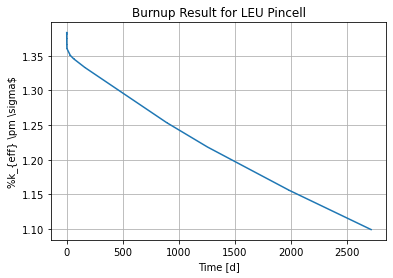

In [3]:
time,k = results.get_eigenvalue()
time /= (24*60*60)

plt.errorbar(time,k[:,0],yerr=k[:,1])
plt.title('Burnup Result for LEU Pincell')
plt.xlabel('Time [d]')
plt.ylabel('%k_{eff} \pm \sigma$')
plt.grid()

Text(0, 0.5, 'Number of atoms Cs137')

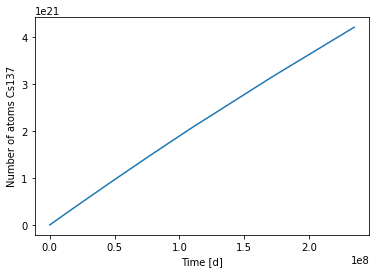

In [4]:
time, cs137 = results.get_atoms("1","Cs137")
plt.plot(time,cs137,label="Cs137")
plt.xlabel("Time [d]")
plt.ylabel("Number of atoms Cs137")

Text(0, 0.5, 'Number of atoms Pu239')

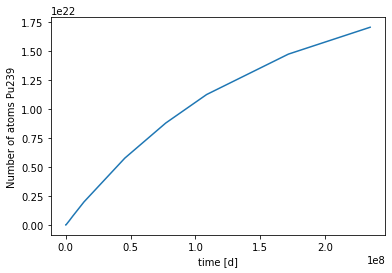

In [5]:
time, Pu239 = results.get_atoms("1","Pu239")
plt.plot(time,Pu239,label="Pu239")
plt.xlabel("time [d]")
plt.ylabel("Number of atoms Pu239")

Text(0, 0.5, 'Number of atoms')

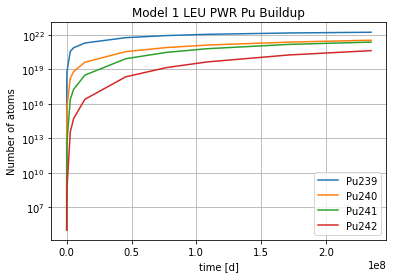

In [6]:
time, Pu240 = results.get_atoms("1","Pu240")
time, Pu241 = results.get_atoms("1","Pu241")
time, Pu242 = results.get_atoms("1","Pu242")

plt.semilogy(time,Pu239,label="Pu239")
plt.semilogy(time,Pu240,label="Pu240")
plt.semilogy(time,Pu241,label="Pu241")
plt.semilogy(time,Pu242,label="Pu242")
plt.legend()
plt.grid()
plt.title("Model 1 LEU PWR Pu Buildup")
plt.xlabel("time [d]")
plt.ylabel("Number of atoms")

Text(0, 0.5, 'Fraction Pu239')

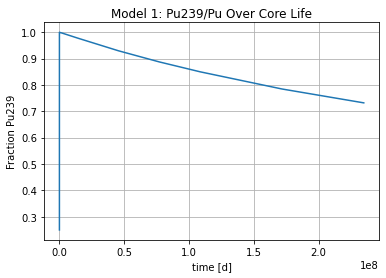

In [7]:
total_pu = Pu239 + Pu240 + Pu241 + Pu242
Pu239_frac = Pu239/total_pu

plt.plot(time,Pu239_frac,label="Fraction Pu239")
plt.grid()
plt.title("Model 1: Pu239/Pu Over Core Life")
plt.xlabel("time [d]")
plt.ylabel("Fraction Pu239")